# Sanjay Regi Philip Assignment 5.1

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


In [1]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy

 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer ##scikit-learn version < 1.0 required
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS) ## CountVectorizer requires stopwords as list

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

import logging
logging.captureWarnings(True)

In [2]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [3]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [4]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [5]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<AxesSubplot: xlabel='category'>

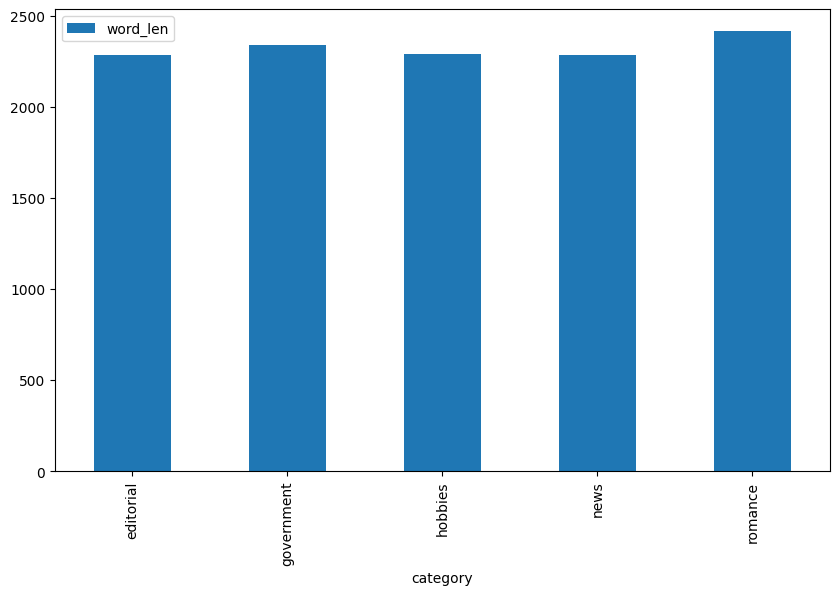

In [6]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [7]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [8]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The dataframe count_text_vectors is a document matrix that takes the text from the selected categories of the brown corprus. It describes the token counts of documents in the selected categories of documents. The tfidf_text_vectors is also a document matrix from the selected cateogries of the brown corpus and instead contains TF-IDF features. The difference with the tfidf_text_vectors is that it both counts the frequency of tokens but also how important the token is to the text where as the count_text_vectors simply provides the frequency of a token in text.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [9]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [10]:
#display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [11]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([18.17705433, 25.86545606, 29.54609649, 14.40020472, 12.0111884 ])

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: When creating a graph of the word length of the original brown categories, we find that the word lengths are almost the same accross all 5 categories and so a successful topic model should also reflect similar lengths across the topics. When viewing the sum of results of the NMF model, we see the model categorizes a larger portion of the words under the 2nd and 3rd topics than the other remaining 3. That indicates that this topic model may not be performing as well as expected.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [12]:
# Your code here
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
lsa_W_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
lsa_H_text_matrix = lsa_text_model.components_

In [13]:
lsa_W_text_matrix.sum(axis=0)/lsa_W_text_matrix.sum()*100.0

array([111.14707411,  -5.04956922,  -8.92711266,   2.13287762,
         0.69673015])

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: This LSA Model seems to perform even more poorly than the MNF model as it is attributing almost all of the words to the first topic in a very imbalanced manner when we know that the tokens should ideally be distrubted accross all 5 tokens. This model does not seem to perform the topic modeling very well.

In [14]:
# call display_topics on your model
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: The display topics output shows that a much larger importance is given to topic 03 and the terms mrs (29.45), club (6.53), game (6.12), jr (5.60), university (5.20) than any other topic.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [15]:
# Fit your LDA model here
# Your code here
lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [16]:
# Call `display_topics` on your fitted model here
#display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names_out())
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


In [17]:
W_lda_text_matrix.sum(axis=0)/W_lda_text_matrix.sum()*100.0

array([18.27700692, 22.10735909, 31.18127143,  7.31815768, 21.11620489])

Q: What inference do you draw from the displayed topics for your LDA model? 

A: The importance of the different words seems to have less variance in this model than it does in the other. Additionally, there are some words such as "said" that appear in 2 topics. The displayed topics here seem to show less of an imbalance in the importance of the individual words.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: The LDA model seems to distribute the importance of the words better than the other models and is almost fairly distributed except for that it underweights the 4th topic and overweights the 3rd topic.

### Please note that there is a large deprecation warning given when using the pyLDAvis package. There was no option to remove this warning but please continue scrolling to see the end of the assignment.

In [18]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/opt/anaconda3/envs/ADS509/lib/python3.10/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/opt/anaconda3/envs/ADS509/lib/python3.10/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/opt/anaconda3/envs/ADS509/lib/python3.10/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/opt/anaconda3/envs/ADS509/lib/python3.10/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.b

In [19]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Similar to how we saw when looking at the the sum of results, we see that topic 4 seems to have much less words attributed than the other topics and that topic 3 seems to have more than the others. This indicates that the words are not distributed to the 5 topics completely evenly, but seem to be better than the other models.